# V1

In [5]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

In [9]:
# Load the models
loaded_generator_v1 = load_model('generator_model.h5')
# Assume z_dim is the dimension of the random noise vector you used during training
z_dim = 100
num_images = 10  # Number of images you want to generate

# Create a batch of random noise vectors
z = np.random.normal(0, 1, (num_images, z_dim))


In [10]:
# Generate new images
generated_images = loaded_generator_v1.predict(z)


1/1 [==============================] - 0s 349ms/step


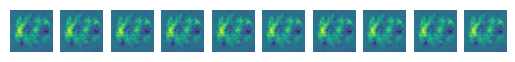

In [11]:
# Assume generated_images is a 4D array with shape (num_images, height, width, channels)
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i, :, :, 10])  # Assume single channel images
    plt.axis('off')

plt.show()


# V2

1/1 [==============================] - 1s 546ms/step


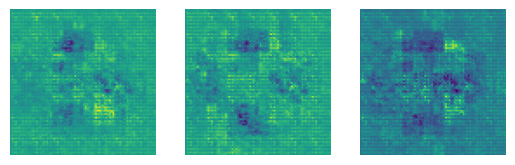

In [12]:
# Load the models
loaded_generator_v2 = load_model('generator_model_v2.h5')
# Assume z_dim is the dimension of the random noise vector you used during training
z_dim = 100
num_images2 = 3  # Number of images you want to generate

# Create a batch of random noise vectors
z = np.random.normal(0, 1, (num_images2, z_dim))

# Generate new images
generated_images_v2 = loaded_generator_v2.predict(z)

# Assume generated_images is a 4D array with shape (num_images2, height, width, channels)
for i in range(num_images2):
    plt.subplot(1, num_images2, i + 1)
    plt.imshow(generated_images_v2[i, :, :, 10])  # Assume single channel images
    plt.axis('off')

plt.show()

# cGAN

1/1 [==============================] - 0s 126ms/step


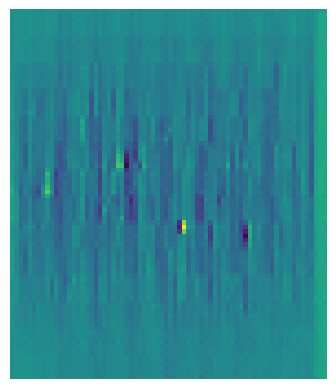

In [5]:
# Load the saved models
generator_cgan = load_model('cgan_generator_model_v1.h5')


z_dim = 100  # Dimension of the noise vector
num_images = 1  # Number of images to generate
label = 0  # 0 for non-schizophrenic, 1 for schizophrenic

# we collapse the y-axis this time around

noise = np.random.normal(0, 1, (num_images, z_dim))
labels = np.array([label] * num_images)

# Generate new images conditioned on the specified labels
generated_images = generator_cgan.predict([noise, labels])

# Plot the generated images
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    # Assume single-channel images, adjust the slice index as needed
    plt.imshow(generated_images[i, :,12,:])
    plt.axis('off')

plt.show()


Compare it against real images

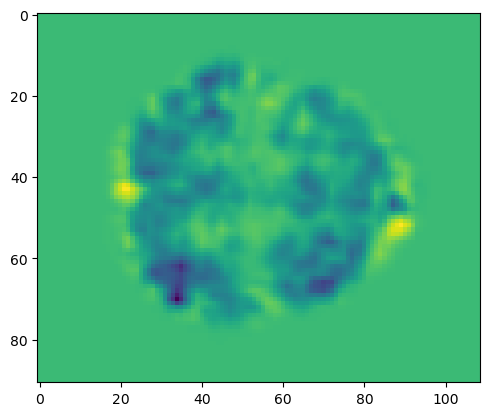

In [19]:
schizo_img_test = nib.load("../4D/A00009280_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz")
schizo_img_data = schizo_img_test.get_fdata()
imgplot1 = plt.imshow(schizo_img_data[:, :, 60, 50])

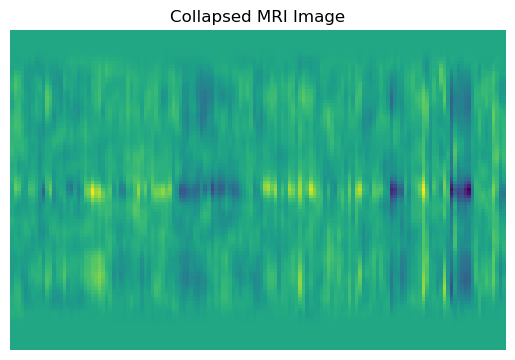

In [29]:
# Collapse the MRI image along the y-axis
collapsed_schizo_img = np.sum(schizo_img_data, axis=1)

# Select a specific slice along the z-axis and a time frame
z_slice = 60  # Adjust this value as needed

# Plot the collapsed image
plt.imshow(collapsed_schizo_img[:, 50, :])
plt.title('Collapsed MRI Image')
plt.axis('off')
plt.show()


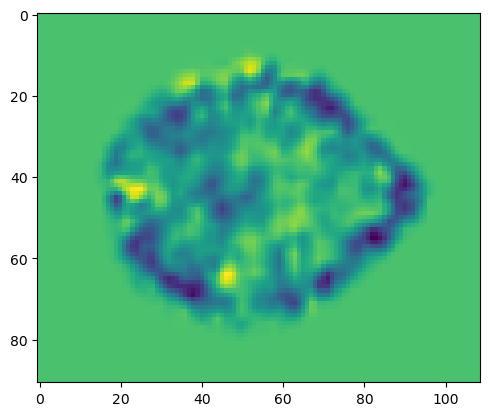

In [78]:
control_img_test = nib.load("../4D/A00007409_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz")
control_img_data = control_img_test.get_fdata()
imgplot2 = plt.imshow(control_img_data[:, :, 60, 50])

# WGAN

1/1 [==============================] - 9s 9s/step


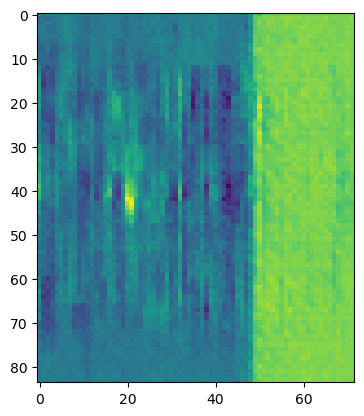

In [3]:
# Load the saved generator model
generator_wgan = load_model('wgan_generator_model_v3.h5')

z_dim = 100  # Dimension of the noise vector
num_images = 1  # Number of images to generate

# Generate random noise as input for the generator
noise = np.random.normal(0, 1, (num_images, z_dim))

# Generate new images using the generator
generated_images = generator_wgan.predict(noise)

# Plot the generated images
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i, :, 50, :])   # x,z,t
    plt.axis('on')

plt.show()


In [4]:
# Collapse the actual MRI image along the y-axis
collapsed_schizo_img = np.sum(schizo_img_data, axis=1)


# Plot the collapsed actual image
plt.figure(figsize=(12, 6))

# Plot the collapsed actual image
plt.subplot(1, 2, 1)
imgplot2 = plt.imshow(collapsed_schizo_img[50, :, :])
plt.title('Collapsed Actual Image')
plt.axis('off')

# Plot the generated image
plt.subplot(1, 2, 2)
# first dimension of generated_images is the batch size
plt.imshow(generated_images[0, 50, :,:])
plt.title('Generated Image')
plt.axis('off')

plt.show()



NameError: name 'schizo_img_data' is not defined

# Threshold for WGAN classification

In [27]:
from tensorflow.keras.models import load_model
import scipy.ndimage

def resize_image(image, new_shape):
    factors = (
        new_shape[0]/image.shape[0],
        new_shape[1]/image.shape[1],
        new_shape[2]/image.shape[2]
    )
    return scipy.ndimage.zoom(image, factors, order=1)  # order=1 is bilinear interpolation

# Function to preprocess an image
def preprocess_image(img_data, max_z_size):
    # Collapse one of the axes by summing
    collapsed_img = np.sum(img_data, axis=1)

    # Normalize the image data
    normalized_img = (collapsed_img - np.min(collapsed_img)) / (np.max(collapsed_img) - np.min(collapsed_img)) * 2 - 1

    padded_img = np.pad(normalized_img, ((0, 0), (0, max_z_size - normalized_img.shape[1]), (0, 0)), mode='constant')

    # Resize the image to match the input size of the model
    resized_img = resize_image(padded_img, (84, 84, 72))

    # Expand dimensions to match the model's expected input shape
    final_img = np.expand_dims(resized_img, axis=0)  # Add batch dimension
    final_img = np.expand_dims(final_img, axis=-1)  # Add channel dimension

    return final_img



In [28]:
# Load the critic model from the saved .h5 file
critic_model = load_model('wgan_critic_model_v3.h5')

In [29]:
control_img_test = nib.load("../4D/A00007409_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz")
control_img_data = control_img_test.get_fdata()

schizo_img_test = nib.load("../4D/A00009280_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz")
schizo_img_data = schizo_img_test.get_fdata()

In [37]:
# Maximum Z-dimension size based on your model's training
max_z_size = 144

# Preprocess both schizophrenia and control images
preprocessed_schizo_img = preprocess_image(schizo_img_data, max_z_size)
preprocessed_control_img = preprocess_image(control_img_data, max_z_size)



# Score the preprocessed images
schizo_score = critic_model.predict(preprocessed_schizo_img)
control_score = critic_model.predict(preprocessed_control_img)

# Print the scores
print(f"Schizophrenia Image Score: {schizo_score}")
print(f"Control Image Score: {control_score}")


1/1 [==============================] - 0s 18ms/step
Schizophrenia Image Score: [[-114.22251]]
Control Image Score: [[-76.49439]]


In [38]:
# Now test the whole thing and find the average threshold

# schizohrenia_id that satisfy t>90, 59 in total
met_requirement_schizophrenia_ids = [
    'A00000368', 'A00000456', 'A00000541', 'A00000838', 'A00001251', 'A00001452', 'A00004507',
    'A00006754', 'A00009280', 'A00012767', 'A00013216', 'A00014607', 'A00014719', 'A00014804',
    'A00014830', 'A00015201', 'A00015648', 'A00016197', 'A00016720', 'A00016723', 'A00017147',
    'A00018317', 'A00018403', 'A00018434', 'A00018979', 'A00019293', 'A00020414', 'A00020602', 
    'A00020787', 'A00021591', 'A00021598', 'A00023158', 'A00023246', 'A00023590', 'A00023750', 
    'A00024198', 'A00024228', 'A00024568', 'A00024684', 'A00024953', 'A00024959', 'A00027410', 
    'A00027537', 'A00028303', 'A00028404', 'A00028408', 'A00028805', 'A00028806', 'A00031186', 
    'A00031597', 'A00034273', 'A00035003', 'A00035485', 'A00037034', 'A00037224', 'A00037619', 
    'A00037649', 'A00038441', 'A00038624']

 # 82 controls that met requirement
met_requirement_control_ids = [
    'A00000300', 'A00002198', 'A00003150', 'A00004087', 'A00007409', 'A00010684', 'A00011265', 'A00011725',
    'A00012995', 'A00013140', 'A00013816', 'A00014839', 'A00014898', 'A00015759', 'A00015826', 'A00018553',
    'A00018716', 'A00019888', 'A00020805', 'A00020895', 'A00020968', 'A00020984', 'A00021058', 'A00021072',
    'A00021081', 'A00021085', 'A00022400', 'A00022490', 'A00022509', 'A00022592', 'A00022619', 'A00022653',
    'A00022687', 'A00022727', 'A00022729', 'A00022773', 'A00022810', 'A00022835', 'A00022837', 'A00022915',
    'A00023095', 'A00023120', 'A00023131', 'A00023143', 'A00023330', 'A00023337', 'A00023730', 'A00023800',
    'A00023848', 'A00023866', 'A00024160', 'A00024301', 'A00024372', 'A00024446', 'A00024535', 'A00024546', 
    'A00024663', 'A00024820', 'A00024932', 'A00024955', 'A00025969', 'A00026945', 'A00027487', 'A00027787', 
    'A00028052', 'A00028406', 'A00028409', 'A00029226', 'A00029452', 'A00031478', 'A00031764', 'A00033214', 
    'A00035751', 'A00036049', 'A00036555', 'A00036844', 'A00037007', 'A00037238', 'A00037318', 'A00037495', 
    'A00037564', 'A00037665'
]

In [44]:
import glob
# Directory containing the image files
directory_path = '../4D/'

# Initialize variables to store the scores
schizophrenia_scores = []
control_scores = []

# Define maximum z-size for padding
max_z_size = 143  # Adjust this based on the critic model's input size

# Process schizophrenia images
for schizophrenia_id in met_requirement_schizophrenia_ids:
    # Construct the file path
    file_path = f"{directory_path}/{schizophrenia_id}_*_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz"
    
    # Load the image
    img_test = nib.load(glob.glob(file_path)[0])
    img_data = img_test.get_fdata()
    
    # Preprocess the image
    preprocessed_img = preprocess_image(img_data, max_z_size)
    

    # Get the score from the critic model
    score = critic_model.predict(preprocessed_img)
    schizophrenia_scores.append(score[0][0])

# Process control images
for control_id in met_requirement_control_ids:
    # Construct the file path
    file_path = f"{directory_path}/{control_id}_*_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz"
    
    # Load the image
    img_test = nib.load(glob.glob(file_path)[0])
    img_data = img_test.get_fdata()
    
    # Preprocess the image
    preprocessed_img = preprocess_image(img_data, max_z_size)
    

    # Get the score from the critic model
    score = critic_model.predict(preprocessed_img)
    control_scores.append(score[0][0])

# Calculate the average scores
average_schizophrenia_score = np.mean(schizophrenia_scores)
average_control_score = np.mean(control_scores)

# Print the results
print(f"Average Schizophrenia Score: {average_schizophrenia_score}")
print(f"Average Control Score: {average_control_score}")


1/1 [==============================] - 0s 16ms/step
Average Schizophrenia Score: -85.81623840332031
Average Control Score: -92.39866638183594
